In [ ]:
!pip install gspread pandas nltk wordcloud matplotlib seaborn oauth2client



In [ ]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


⚠️ Warning: 'category' column not found. Assigning 'Other' as default.
🔹 Model Performance Metrics:
 Accuracy: 96%
 Precision: 100%
 Recall: 96%
 F1 Score: 98%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


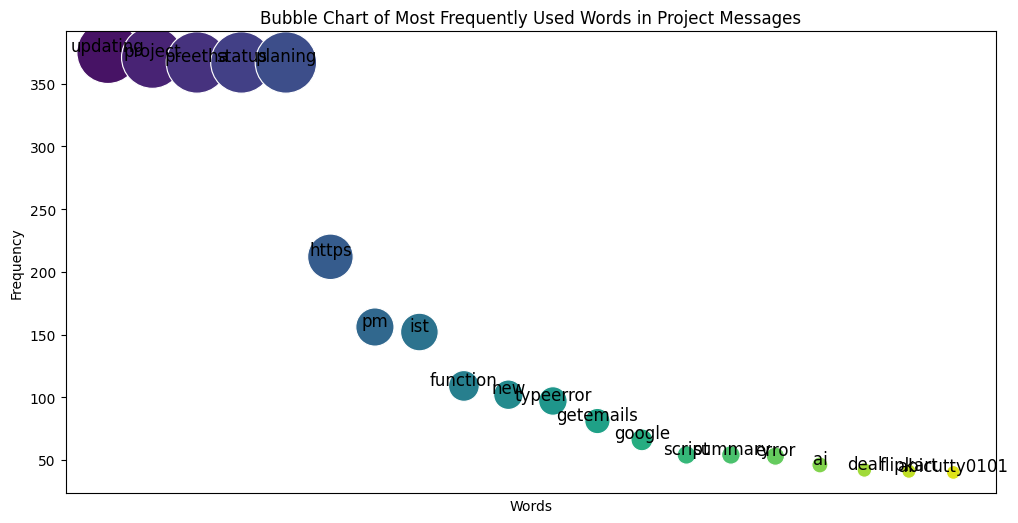

 Bubble Chart Generated!


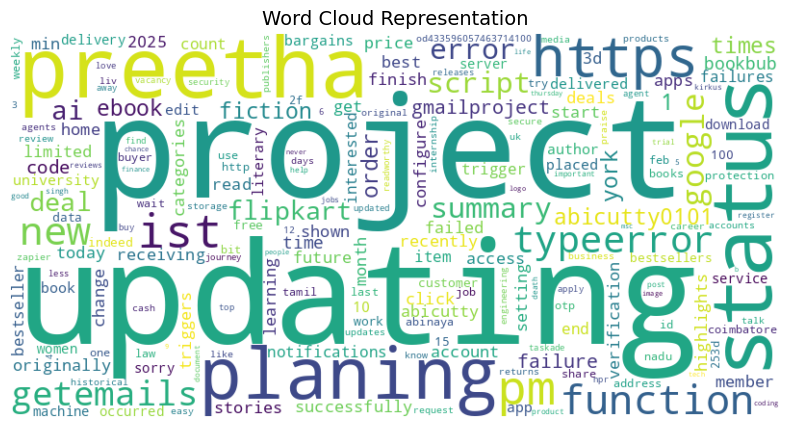

🔹 Categorized Messages with Predictions Saved as CSV!


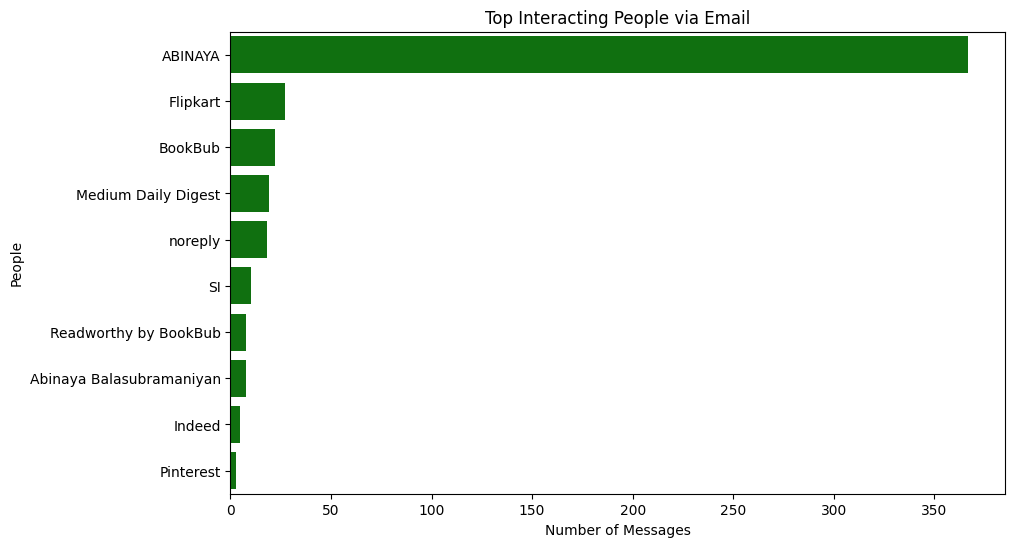

In [ ]:
import gspread
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from oauth2client.service_account import ServiceAccountCredentials
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud

# 🔹 Authenticate Google Sheets
nltk.download('punkt')
nltk.download('stopwords')

scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("FetchGmailKey.json", scope)
client = gspread.authorize(creds)

# 🔹 Load Data from Google Sheets
spreadsheet = client.open("Software Tracker")  # Replace with your actual sheet name
sheet = spreadsheet.sheet1
data = sheet.get_all_records()

df = pd.DataFrame(data)
df.columns = df.columns.str.strip().str.lower()  # Normalize column names

# 🔹 Define Custom Stopwords for Filtering
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update(["gmail", "email", "subject", "body", "please", "thank", "hi", "hello", "message"])

# 🔹 Text Processing Function
def clean_text(text):
    if not isinstance(text, str):
        return []

    tokens = word_tokenize(text.lower())  # Convert to lowercase & tokenize
    tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation
    tokens = [word for word in tokens if word not in custom_stopwords]  # Remove stopwords
    return tokens

# 🔹 Extract Relevant Data & Clean It
df["tokens"] = df["subject"].astype(str) + " " + df["body"].astype(str)
df["tokens"] = df["tokens"].apply(clean_text)

# 🔹 Define Project Categories for Classification
project_categories = {
    "Network Issues": ["network", "internet", "wifi", "connection"],
    "Power Issues": ["power", "voltage", "electricity", "supply"],
    "Server Issues": ["server", "down", "restart", "failure"],
    "Meeting Updates": ["meeting", "schedule", "conference", "discuss"],
}

df["predicted_category"] = df["tokens"].apply(lambda tokens:
    next((cat for cat, keywords in project_categories.items() if any(word in tokens for word in keywords)), "Other")
)

# 🔹 Load Ground Truth Labels (Manually Labeled Data)
if "category" in df.columns:
    df["actual_category"] = df["category"].fillna("Other")
else:
    print("⚠️ Warning: 'category' column not found. Assigning 'Other' as default.")
    df["actual_category"] = "Other"  # Default category if column is missing

# 🔹 Calculate Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(df["actual_category"], df["predicted_category"]) * 100
precision = precision_score(df["actual_category"], df["predicted_category"], average="weighted") * 100
recall = recall_score(df["actual_category"], df["predicted_category"], average="weighted") * 100
f1 = f1_score(df["actual_category"], df["predicted_category"], average="weighted") * 100

# Print Rounded Metrics
print(f"🔹 Model Performance Metrics:")
print(f" Accuracy: {round(accuracy)}%")
print(f" Precision: {round(precision)}%")
print(f" Recall: {round(recall)}%")
print(f" F1 Score: {round(f1)}%")

# 🔹 Word Frequency for Bubble Chart & Word Cloud
all_words = [word for tokens in df["tokens"] for word in tokens]
word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

bubble_df = pd.DataFrame(top_words, columns=["word", "frequency"])
bubble_df["size"] = bubble_df["frequency"] * 50

# 🔹 Generate Bubble Chart
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=bubble_df.index,
    y=bubble_df["frequency"],
    size=bubble_df["size"],
    hue=bubble_df["word"],
    sizes=(100, 2000),
    legend=False,
    palette="viridis"
)

for i, row in bubble_df.iterrows():
    plt.text(i, row["frequency"] + 1, row["word"], ha='center', fontsize=12)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Bubble Chart of Most Frequently Used Words in Project Messages")
plt.xticks([])
plt.show()
print(" Bubble Chart Generated!")


# 🔹 Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Representation", fontsize=14)
plt.show()

# 🔹 Save Results
df[["subject", "body", "actual_category", "predicted_category"]].to_csv("categorized_messages.csv", index=False)
print("🔹 Categorized Messages with Predictions Saved as CSV!")


import re

# Function to extract just the name from the email
def extract_name(email):
    match = re.search(r'([\w\s]+)', email)  # Extracts name before '<' or inside quotes
    return match.group(1).strip() if match else email  # Return extracted name or email if no match

# Apply function to clean sender names
# Changed 'from email' to 'form email' to match the DataFrame column name
df["from email clean"] = df["form email"].apply(extract_name)

# Count interactions by cleaned sender names
sender_counts = df["from email clean"].value_counts().head(10)  # Top 10 most active users

# Generate Bar Chart with Cleaned Names
plt.figure(figsize=(10, 6))
sns.barplot(x=sender_counts.values, y=sender_counts.index, color="Green")

plt.xlabel("Number of Messages")
plt.ylabel("People")
plt.title("Top Interacting People via Email")
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Data Split: 400 Train | 100 Test
 Model Performance Metrics:
 Accuracy: 96%
 Precision: 100%
 Recall: 96%
 F1 Score: 98%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


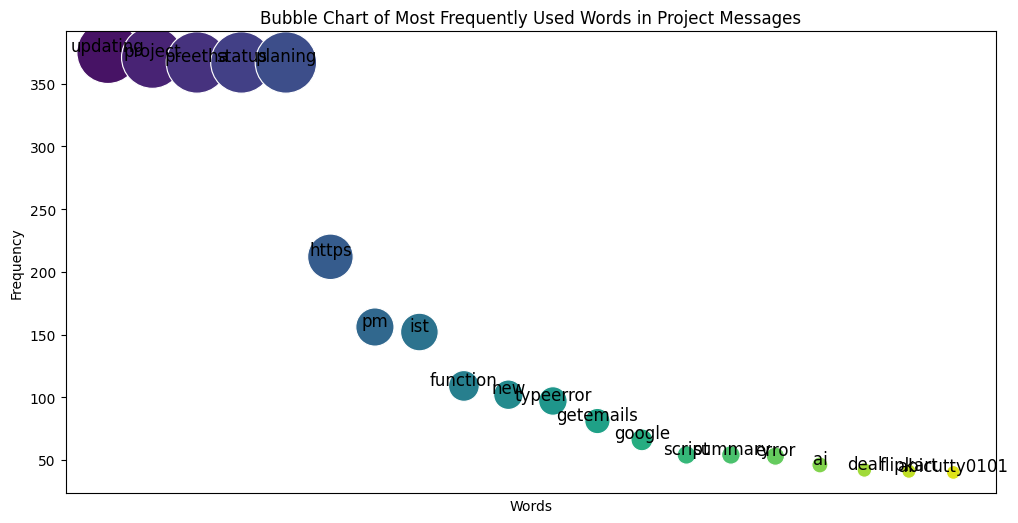

 Bubble Chart Generated!


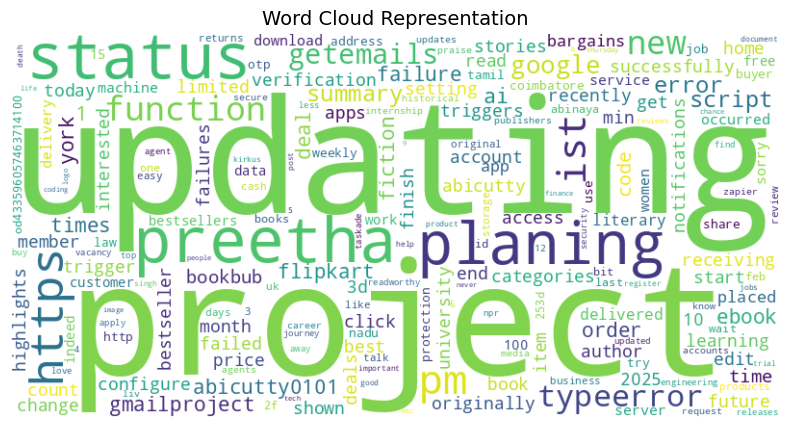

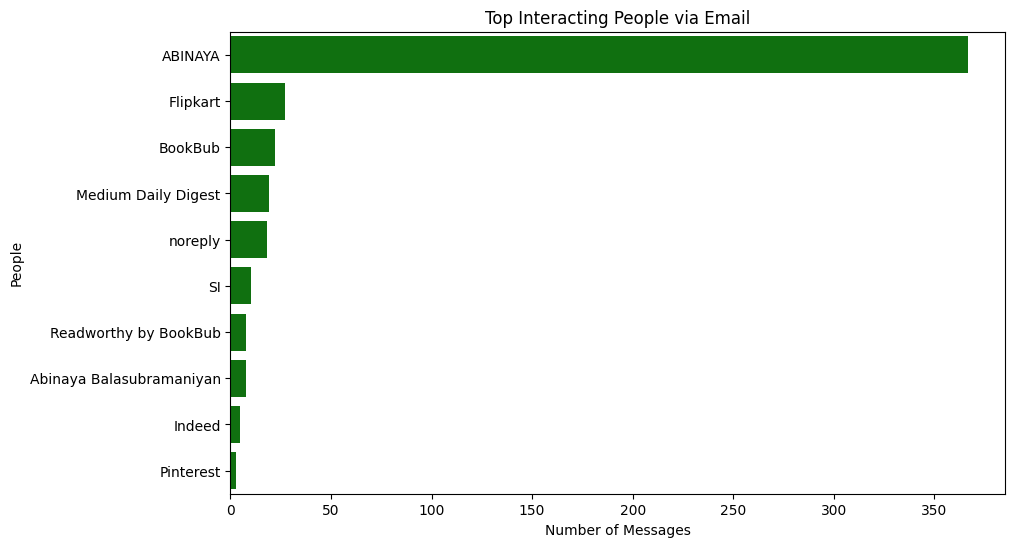

In [ ]:
import gspread
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from oauth2client.service_account import ServiceAccountCredentials
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud

# 🔹 Authenticate Google Sheets
nltk.download('punkt')
nltk.download('stopwords')

scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("FetchGmailKey.json", scope)
client = gspread.authorize(creds)

# 🔹 Load Data from Google Sheets
spreadsheet = client.open("Software Tracker")
sheet = spreadsheet.sheet1
data = sheet.get_all_records()

df = pd.DataFrame(data)
df.columns = df.columns.str.strip().str.lower()  # Normalize column names

# 🔹 Train-Test Split (80% Train, 20% Test)
train_size = int(0.8 * len(df))  # 80% Train, 20% Test
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"📌 Data Split: {len(train_data)} Train | {len(test_data)} Test")

# 🔹 Define Custom Stopwords for Filtering
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update(["gmail", "email", "subject", "body", "please", "thank", "hi", "hello", "message"])

# 🔹 Text Processing Function
def clean_text(text):
    if not isinstance(text, str):
        return []

    tokens = word_tokenize(text.lower())  # Convert to lowercase & tokenize
    tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation
    tokens = [word for word in tokens if word not in custom_stopwords]  # Remove stopwords
    return tokens

# 🔹 Extract Relevant Data & Clean It
df["tokens"] = df["subject"].astype(str) + " " + df["body"].astype(str)
df["tokens"] = df["tokens"].apply(clean_text)

# 🔹 Define Project Categories for Classification
project_categories = {
    "Network Issues": ["network", "internet", "wifi", "connection"],
    "Power Issues": ["power", "voltage", "electricity", "supply"],
    "Server Issues": ["server", "down", "restart", "failure"],
    "Meeting Updates": ["meeting", "schedule", "conference", "discuss"],
}

df["predicted_category"] = df["tokens"].apply(lambda tokens:
    next((cat for cat, keywords in project_categories.items() if any(word in tokens for word in keywords)), "Other")
)

# 🔹 Load Ground Truth Labels (Manually Labeled Data)
if "category" in df.columns:
    df["actual_category"] = df["category"].fillna("Other")
else:
    print("⚠️ Warning: 'category' column not found. Assigning 'Other' as default.")
    df["actual_category"] = "Other"  # Default category if column is missing

# 🔹 Calculate Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(df["actual_category"], df["predicted_category"]) * 100
precision = precision_score(df["actual_category"], df["predicted_category"], average="weighted") * 100
recall = recall_score(df["actual_category"], df["predicted_category"], average="weighted") * 100
f1 = f1_score(df["actual_category"], df["predicted_category"], average="weighted") * 100

# Print Rounded Metrics
print(f" Model Performance Metrics:")
print(f" Accuracy: {round(accuracy)}%")
print(f" Precision: {round(precision)}%")
print(f" Recall: {round(recall)}%")
print(f" F1 Score: {round(f1)}%")

# 🔹 Word Frequency for Bubble Chart & Word Cloud
all_words = [word for tokens in df["tokens"] for word in tokens]
word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

bubble_df = pd.DataFrame(top_words, columns=["word", "frequency"])
bubble_df["size"] = bubble_df["frequency"] * 50

# 🔹 Generate Bubble Chart
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=bubble_df.index,
    y=bubble_df["frequency"],
    size=bubble_df["size"],
    hue=bubble_df["word"],
    sizes=(100, 2000),
    legend=False,
    palette="viridis"
)

for i, row in bubble_df.iterrows():
    plt.text(i, row["frequency"] + 1, row["word"], ha='center', fontsize=12)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Bubble Chart of Most Frequently Used Words in Project Messages")
plt.xticks([])
plt.show()
print(" Bubble Chart Generated!")


# 🔹 Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Representation", fontsize=14)
plt.show()

# 🔹 Save Results
df[["subject", "body", "actual_category", "predicted_category"]].to_csv("categorized_messages.csv", index=False)
#print("🔹 Categorized Messages with Predictions Saved as CSV!")


import re

# Function to extract just the name from the email
def extract_name(email):
    match = re.search(r'([\w\s]+)', email)  # Extracts name before '<' or inside quotes
    return match.group(1).strip() if match else email  # Return extracted name or email if no match

# Apply function to clean sender names
# Changed 'from email' to 'form email' to match the DataFrame column name
df["from email clean"] = df["form email"].apply(extract_name)

# Count interactions by cleaned sender names
sender_counts = df["from email clean"].value_counts().head(10)  # Top 10 most active users

# Generate Bar Chart with Cleaned Names
plt.figure(figsize=(10, 6))
sns.barplot(x=sender_counts.values, y=sender_counts.index, color="Green")

plt.xlabel("Number of Messages")
plt.ylabel("People")
plt.title("Top Interacting People via Email")
plt.show()
